In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from time import sleep as fallasleep
import os, sys

In [2]:
import krakenex
from pykrakenapi import KrakenAPI

In [3]:
color_box = ['#1f77b4','#ff7f0e','#2ca02c','#d62728',
             '#9467bd','#8c564b','#e377c2','#7f7f7f',
             '#bcdb22','#17becf']

In [4]:
api = krakenex.API()
k = KrakenAPI(api)
coins = ["ETH", "BTC", "XRP", "ADA", "DOT"]
gapmin= 1440
coins = [coin+"USD" for coin in coins]
df = {}
colormapper = {}
for _,coin in enumerate(coins):
    data, last = k.get_ohlc_data(coin, interval = gapmin, ascending = True)
    df[coin]=data.drop(['time', 'count'], axis=1)
    colormapper[coin] = color_box[_]
    fallasleep(1)


In [5]:
df_close = pd.DataFrame(columns=coins)
for coin in coins:
    df_close[coin] = df[coin]['close']

In [6]:
df_close.isna().sum()

ETHUSD      0
BTCUSD      0
XRPUSD      0
ADAUSD      0
DOTUSD    272
dtype: int64

In [7]:
df_close = df_close.dropna()
df_close.isna().sum()

ETHUSD    0
BTCUSD    0
XRPUSD    0
ADAUSD    0
DOTUSD    0
dtype: int64

In [8]:
df_close.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-18,422.62,11957.0,0.30292,0.137218,3.1099
2020-08-19,407.57,11757.4,0.28992,0.129678,2.9175
2020-08-20,416.20,11864.6,0.29246,0.134305,2.9090


In [9]:
df_close_diff = df_close.apply(np.log).diff().dropna()
df_close_diff.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-19,-0.036261,-0.016834,-0.043864,-0.056516,-0.063863
2020-08-20,0.020953,0.009076,0.008723,0.035059,-0.002918
2020-08-21,-0.070599,-0.029240,-0.046364,-0.087043,0.056341


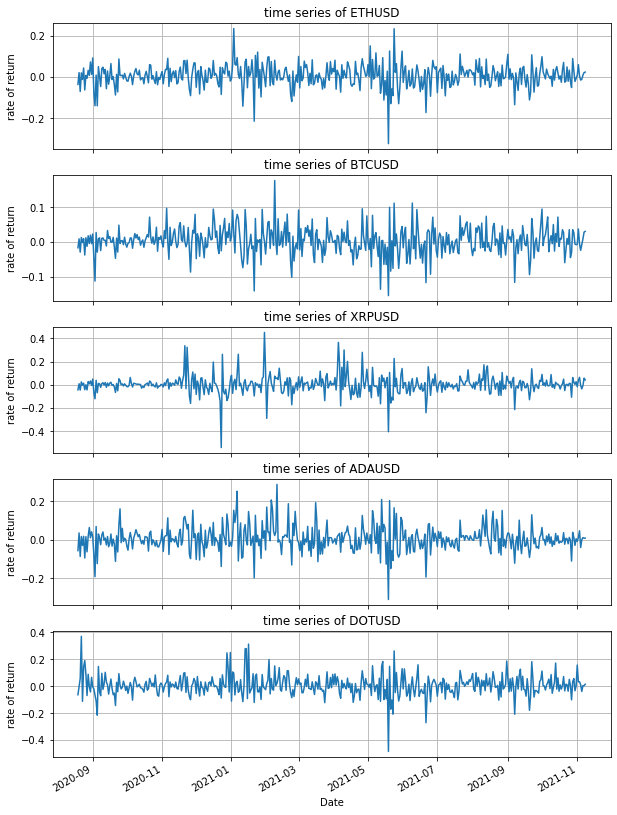

In [10]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(len(df_close_diff.columns),1,figsize=(10,15))
for _,col in enumerate(df_close_diff):
    ax[_].plot(df_close_diff.index, df_close_diff[col].values)
    ax[_].set_title(f"time series of {col}")
    ax[_].set_ylabel("rate of return")
    ax[_].set_xlabel("Date")
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

### Mean-Variance Optimization (no cardinality constraint)
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2}x^TQx - r^Tx\\
        &\text{subject to}&& \mathbf{1}^Tx = 1\\
        &&& x \in [0,1]\\
\end{aligned}
$$

In [18]:
Q = df_close_diff.cov().values
r = df_close_diff.mean().values

### Using Gurobi

In [19]:
from gurobipy import *

In [43]:
m = Model("MVO")
x = {}
n = len(Q)
lam = 0.5
x = m.addMVar(shape=n,vtype=GRB.CONTINUOUS, lb=0, ub=1, name=coins)
obj = 0.5 * lam * (x @ Q @ x) - (1 - lam) * (r @ x)
m.addConstr(x.sum()==1)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

for v in m.getVars():
    print('%s: %g' % (v.varName, round(10*v.x,2)))

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x976b3672
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 3e-03]
  QObjective range [8e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 5 columns, 5 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 4
 AA' NZ     : 1.000e+01
 Factor NZ  : 1.500e+01
 Factor Ops : 5.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.61103825e+05 -1.61375683e+05  3.50e+03 8.64e-02  2.50e+05     0s
   1   6.70320630e+03 -6.74305003e+03  2.66e+02 3.48e-09

### Using Qiskit

##### QAOA

In [44]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

In [54]:
%matplotlib inline

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
# adjacency = nx.adjacency_matrix(G).todense()
#
nqubits = n

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for i in range(n-1):  # pairs of nodes
    for j in range(i+1,n):
        qc_p.rzz(2 * gamma, i, j)
        qc_p.barrier()

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

┌─────────┐┌────────────────┐                             ░      »
q_0: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├──■──────────────────────■───░───■──»
     ├─────────┤├────────────────┤┌─┴─┐┌────────────────┐┌─┴─┐ ░   │  »
q_1: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──»
     ├─────────┤├────────────────┤└───┘└────────────────┘└───┘ ░ ┌─┴─┐»
q_2: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─────────────────────────────░─┤ X ├»
     ├─────────┤├────────────────┤                             ░ └───┘»
q_3: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─────────────────────────────░──────»
     ├─────────┤├────────────────┤                             ░      »
q_4: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─────────────────────────────░──────»
     └─────────┘└────────────────┘                             ░      »
«                             ░                              ░      »
«q_0: ────────────────────■───░───■──────────────────────■───░───■──»
«                         │   ░   │                      │   ░   │  »
«q_1: ────────────────────┼───░───┼──────────────────────┼───░───┼──»
«     ┌────────────────┐┌─┴─┐ ░   │                      │   ░   │  »
«q_2: ┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───┼──»
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │  »
«q_3: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──»
«                             ░ └───┘└────────────────┘└───┘ ░ ┌─┴─┐»
«q_4: ────────────────────────░──────────────────────────────░─┤ X ├»
«                             ░                              ░ └───┘»
«                             ░                              ░      »
«q_0: ────────────────────■───░──────────────────────────────░──────»
«                         │   ░                              ░      »
«q_1: ────────────────────┼───░───■──────────────────────■───░───■──»
«                         │   ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │  »
«q_2: ────────────────────┼───░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──»
«                         │   ░ └───┘└────────────────┘└───┘ ░ ┌─┴─┐»
«q_3: ────────────────────┼───░──────────────────────────────░─┤ X ├»
«     ┌────────────────┐┌─┴─┐ ░                              ░ └───┘»
«q_4: ┤ Rz(2*$\gamma$) ├┤ X ├─░──────────────────────────────░──────»
«     └────────────────┘└───┘ ░                              ░      »
«                             ░                              ░      »
«q_0: ────────────────────────░──────────────────────────────░──────»
«                             ░                              ░      »
«q_1: ────────────────────■───░───■──────────────────────■───░──────»
«                         │   ░   │                      │   ░      »
«q_2: ────────────────────┼───░───┼──────────────────────┼───░───■──»
«     ┌────────────────┐┌─┴─┐ ░   │                      │   ░ ┌─┴─┐»
«q_3: ┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░─┤ X ├»
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ └───┘»
«q_4: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░──────»
«                             ░ └───┘└────────────────┘└───┘ ░      »
«                             ░                              ░      »
«q_0: ────────────────────────░──────────────────────────────░──────»
«                             ░                              ░      »
«q_1: ────────────────────────░──────────────────────────────░──────»
«                             ░                              ░      »
«q_2: ────────────────────■───░───■──────────────────────■───░──────»
«     ┌────────────────┐┌─┴─┐ ░   │                      │   ░      »
«q_3: ┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───■──»
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ ┌─┴─┐»
«q_4: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─┤ X ├»
«                             ░ └───┘└────────────────┘└───┘ ░ └───┘»
«                             ░ 
«q_0: ────────────────────────░─
«                             ░ 
«q_1: ────────────────────────░─
«

##### VQE

### k-medoids clustering for index-tracking
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & -\alpha \cdot x^TDx + \beta \cdot 1^TDx\\
        &\text{subject to}&& \mathbf{1}^Tx = 1\\
        &&& x \in {0,1}
\end{aligned}
$$

In [69]:
m = Model("MVO")
x = {}
n = len(Q)
k = 2
beta = 1 / (2 * (k-1))
alpha = 1 / (n-1)
D = df_close_diff.corr()
D = 0.5*(1- D)
D = D.apply(np.sqrt)
D = 1 - (-0.5 * D).apply(np.exp)
D = D.values

x = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = -beta * (x @ D @ x) + alpha * (np.ones(n).dot(D) @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

for v in m.getVars():
    print('%s: %g' % (v.varName, v.x))

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xb4cd3273
Model has 10 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e-01]
  QObjective range [3e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 0.2192693
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -3.998431e-01, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.39984    0    5    0.21927   -0.39984   282%     -    0s
H    0     0                       0.